# Multigrid as a Neural Network



In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
pyplot.style.use('ggplot')

def Laplacian(n, stencil=[-1, 2, -1], periodic=True):
    A = stencil[1] * numpy.eye(n) + stencil[2] * numpy.eye(n, k=1) + stencil[0] * numpy.eye(n, k=-1)
    if periodic:
        A[0,-1] += stencil[0]
        A[-1,0] += stencil[2]
    return A

Laplacian(4)

array([[ 2., -1.,  0., -1.],
       [-1.,  2., -1.,  0.],
       [ 0., -1.,  2., -1.],
       [-1.,  0., -1.,  2.]])

[[ 1.   0.   0.   0.   0. ]
 [ 0.5  0.5 -0.  -0.  -0. ]
 [ 0.   1.   0.   0.   0. ]
 [-0.   0.5  0.5 -0.  -0. ]
 [ 0.   0.   1.   0.   0. ]
 [-0.  -0.   0.5  0.5 -0. ]
 [ 0.   0.   0.   1.   0. ]
 [-0.  -0.  -0.   0.5  0.5]
 [ 0.   0.   0.   0.   1. ]
 [ 0.5 -0.  -0.  -0.   0.5]]
[[ 1.   0.5  0.  -0.   0.  -0.   0.  -0.   0.   0.5]
 [ 0.   0.5  1.   0.5  0.  -0.   0.  -0.   0.  -0. ]
 [ 0.  -0.   0.   0.5  1.   0.5  0.  -0.   0.  -0. ]
 [ 0.  -0.   0.  -0.   0.   0.5  1.   0.5  0.  -0. ]
 [ 0.  -0.   0.  -0.   0.  -0.   0.   0.5  1.   0.5]]


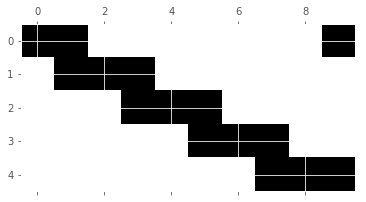

In [2]:
def Interpolation(A):
    """Interpolation using the exact construction.
    This maintains sparsity in 1D, but the approach will not in higher dimensions.
    """
    Aff = A[1::2, 1::2]
    Afc = A[1::2, 0::2]
    Acf = A[0::2, 1::2]
    nf, nc = Afc.shape
    P = numpy.zeros((nf+nc, nc))
    P[::2] = numpy.eye(nc)
    # Aff is diagonal in our examples so this solve is trivial
    P[1::2] = -numpy.linalg.solve(Aff, Afc)
    R = numpy.zeros((nc, nf+nc))
    R[:,::2] = numpy.eye(nc)
    R[:,1::2] = -numpy.linalg.solve(Aff, Acf.T).T
    return P, R

A = Laplacian(10, periodic=True)
P, R = Interpolation(A)
print(P)
print(R)
pyplot.spy(R);

In [3]:
def randmean0(shape):
    x = numpy.random.rand(shape)
    return x - numpy.mean(x)

def Additive2Level(A):
    P, R = Interpolation(A)
    Ac = R @ A @ P
    # Use pseudo-inverse because of the null space for periodic.
    # We will replace with a recursive call below.
    Acinv = numpy.linalg.pinv(Ac)
    D = 1/A.diagonal()
    D[::2] = 0
    def apply(b):
        return P @ Acinv @ R @ b + D * b
    return apply

def Test(A, ntests=1, MG=Additive2Level, **kwargs):
    apply = MG(A, **kwargs)
    for i in range(ntests):
        x = randmean0(len(A))
        b = A @ x
        x2 = apply(b)
        # This projection is needed in the periodic case
        x3 = x2 - numpy.mean(x2)
        print('{}: |e2|={:8e} |e3|={:8e}'.format(i,
                                                 numpy.linalg.norm(x2 - x), 
                                                 numpy.linalg.norm(x3 - x)))

A = Laplacian(5, periodic=False)
Test(A, ntests=5)

0: |e2|=2.095500e-16 |e3|=1.494683e-16
1: |e2|=2.603704e-16 |e3|=3.034923e-16
2: |e2|=3.152427e-16 |e3|=3.034130e-16
3: |e2|=1.468687e-16 |e3|=1.791055e-16
4: |e2|=2.149938e-16 |e3|=2.288783e-16


In [4]:
A = Laplacian(5, periodic=True)
Test(A, ntests=5)

0: |e2|=2.560742e-01 |e3|=1.820055e-16
1: |e2|=6.120840e-02 |e3|=1.468687e-16
2: |e2|=1.249134e-01 |e3|=5.721958e-17
3: |e2|=1.810112e-01 |e3|=1.475229e-16
4: |e2|=3.660587e-01 |e3|=2.077037e-16


In [5]:
def AdditiveMG(A, level, verbose=False):
    print('Level {} size {}'.format(level, len(A)))
    if level == 0:
        def apply(b):
            print('Coarse solve', A, 'pinv', numpy.linalg.pinv(A))
            return numpy.linalg.pinv(A) @ b
        return apply
    P, R = Interpolation(A)
    Ac = R @ A @ P
    Acinv = AdditiveMG(Ac, level-1)
    D = 1/A.diagonal()
    D[::2] = 0
    def apply(b):
        y = P @ Acinv(R @ b) + D * b
        return y - numpy.mean(y)
    return apply

A = Laplacian(2, periodic=True)
Test(A, MG=AdditiveMG, level=0, verbose=True)

Level 0 size 2
Coarse solve [[ 2. -2.]
 [-2.  2.]] pinv [[ 0.125 -0.125]
 [-0.125  0.125]]
0: |e2|=6.206335e-17 |e3|=7.850462e-17


In [6]:
A = Laplacian(32, periodic=True)
Test(A, MG=AdditiveMG, level=5, verbose=True)

Level 5 size 32
Level 4 size 16
Level 3 size 8
Level 2 size 4
Level 1 size 2
Level 0 size 1
Coarse solve [[0.]] pinv [[0.]]
0: |e2|=4.079294e-16 |e3|=4.086590e-16


In [7]:
# This tests the non-symmetric case, here with
# advection-diffusion discretized using a centered difference.
A = Laplacian(32, stencil=[-2, 2, 0], periodic=True)
Test(A, MG=AdditiveMG, level=5, verbose=True)

Level 5 size 32
Level 4 size 16
Level 3 size 8
Level 2 size 4
Level 1 size 2
Level 0 size 1
Coarse solve [[0.]] pinv [[0.]]
0: |e2|=2.953720e-16 |e3|=2.982312e-16


## Towards neural networks

We would like to use data $(x, b=Ax)$ to train an interpolation operator $P$ and restriction $R$ for this multigrid method.

In [8]:
A = Laplacian(10, periodic=True)